# Introduction to Gaussian processes

Short tutorial inspired by http://katbailey.github.io/post/gaussian-processes-for-dummies/

Other interesting material (seems intuitive) : https://emtiyaz.github.io/pcml15/gp_by_carlos.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
%matplotlib inline

# Plot settings
mpl.rcParams['legend.frameon' ] = False
mpl.rcParams['legend.fontsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize' ] = 18
mpl.rcParams['axes.labelsize' ] = 18
mpl.rcParams['lines.linewidth'] = 2.5

In [2]:
# Define global paramter to build fake data
n=100
xmin=0
xmax=4

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

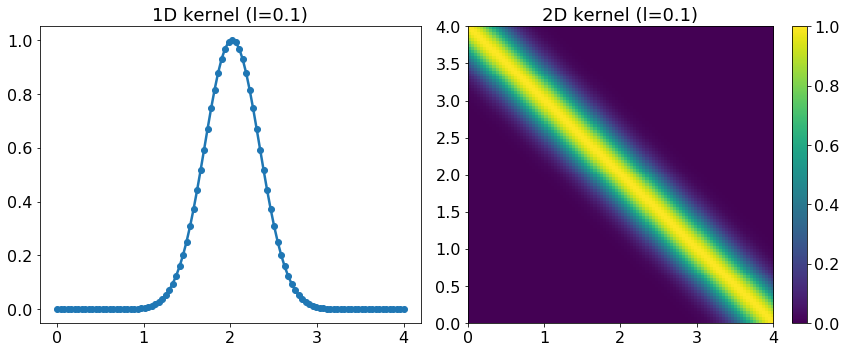

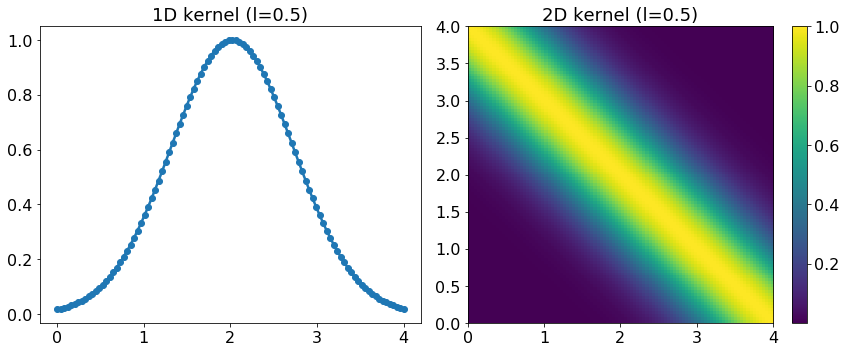

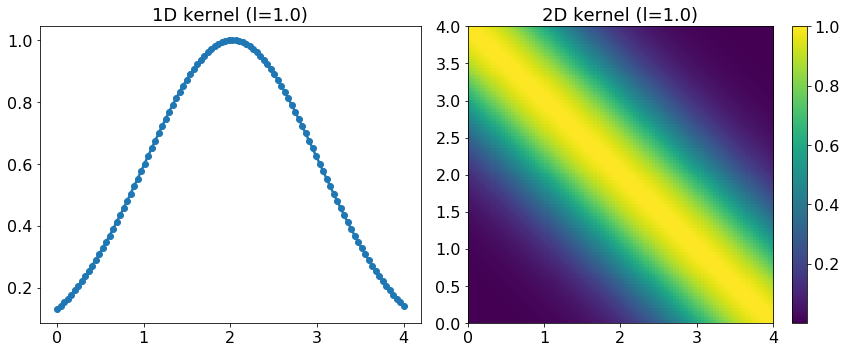

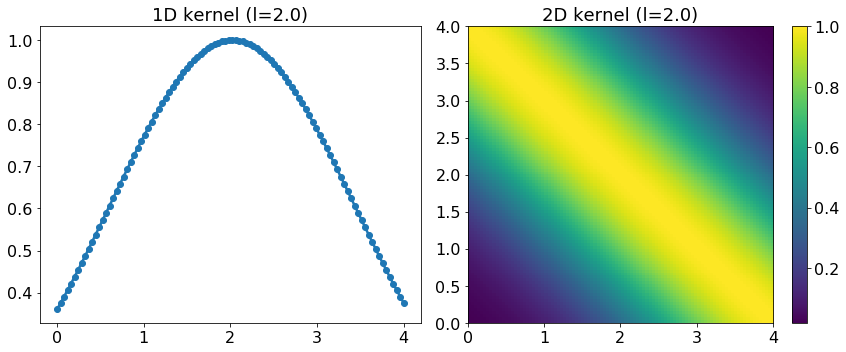

In [3]:
# Plot Kernel function
def plot_kernel_function(para):
    x=np.linspace(xmin,xmax,n).reshape(-1,1)
    myKerr = kernel(x,x,para)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.title('1D kernel (l={:.1f})'.format(para))
    plt.plot( x, myKerr[:,int(n/2)] , 'o-' )
    plt.subplot(1,2,2)
    plt.title('2D kernel (l={:.1f})'.format(para))
    plt.imshow( myKerr , extent=[xmin,xmax,xmin,xmax], aspect='auto')
    plt.colorbar()
    plt.tight_layout()
    
for p in [0.1,0.5,1.0,2.0]:
    plot_kernel_function(p)

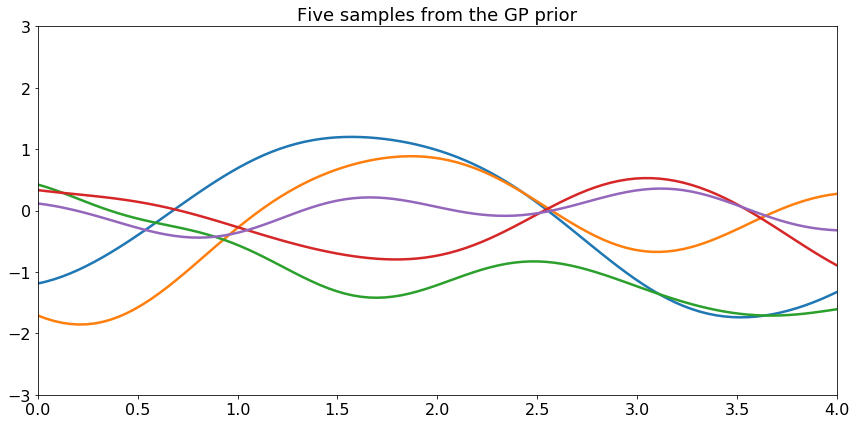

In [4]:
# Test data
ntest=n
xtest = np.linspace(xmin, xmax, ntest).reshape(-1,1)

# Compute the kernel
param = 0.5
K_ss = kernel(xtest, xtest, param)

# Get cholesky decomposition (square root) of the covariance matrix
L = np.linalg.cholesky(K_ss + 1e-12*np.eye(ntest))
f_prior = np.dot(L, np.random.normal(size=(ntest,5)))

# Let's plot 3 sampled functions.
plt.figure(figsize=(12,6))
plt.plot(xtest, f_prior)
plt.axis([xmin, xmax, -3, 3])
plt.title('Five samples from the GP prior')
plt.tight_layout()

In [17]:
# Underlying function
def truth_function(x):
    return 2*x*np.sin(x)

# Noiseless training data
Ndata=5
xtrain = np.sort(0.5*(xmax-xmin)*np.random.rand(Ndata)+xmin).reshape(Ndata,1)
ytrain = truth_function(xtrain)

In [18]:
def perform_gp_prediction(_xtrain,_ytrain,_param):

    # Apply the kernel function to our training points
    K = kernel(_xtrain, _xtrain, _param)
    L = np.linalg.cholesky( K + 1e-12*np.eye(len(_xtrain)) )
    
    # Compute the mean at our test points.
    K_s = kernel(_xtrain, xtest, _param)
    Lk = np.linalg.solve(L, K_s)
    mu = np.dot(Lk.T, np.linalg.solve(L, _ytrain)).reshape((ntest,))
    
    # Compute the standard deviation so we can plot it
    K_ss = kernel(xtest, xtest, _param)
    s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
    stdv = np.sqrt(s2)

    # Get function from the posterior at our test points.
    L = np.linalg.cholesky( K_ss + 1e-12*np.eye(ntest) - np.dot(Lk.T, Lk) )
    f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(ntest,2)))

    # Plots things
    plt.figure(figsize=(12,6))
    plt.plot(np.linspace(xmin,xmax,500),truth_function(np.linspace(xmin,xmax,500)), label='truth' )
    for i in range(len(f_post[1])):
        plt.plot(xtest, f_post[:,i], label='posterior n{:.0f}'.format(i))
    plt.gca().fill_between(xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd", label='$\pm \, 1 \, \sigma$')
    plt.plot(xtest, mu, 'r--', lw=3, label='$\mu(x)$')
    plt.plot(_xtrain, _ytrain,'o', color='black', ms=10, zorder=10, label='data')
    plt.axis([xmin, xmax, -8, 8])
    plt.title('Gaussian Process Interpolation')
    plt.legend()
    plt.tight_layout()
    
    return

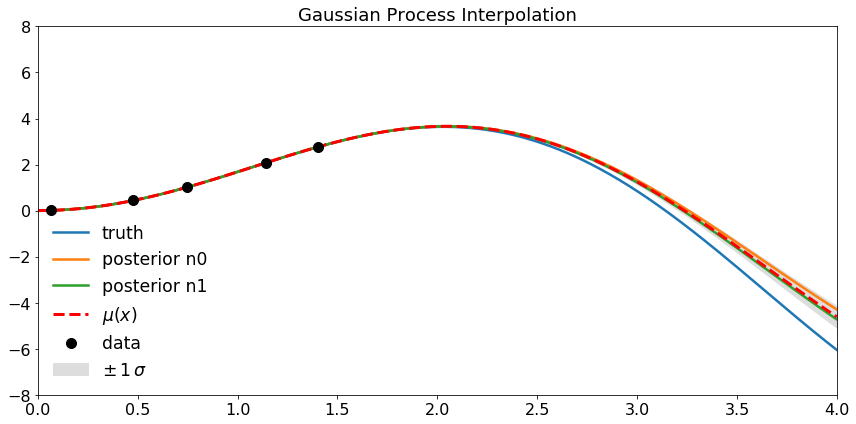

In [19]:
perform_gp_prediction(xtrain,ytrain,5)

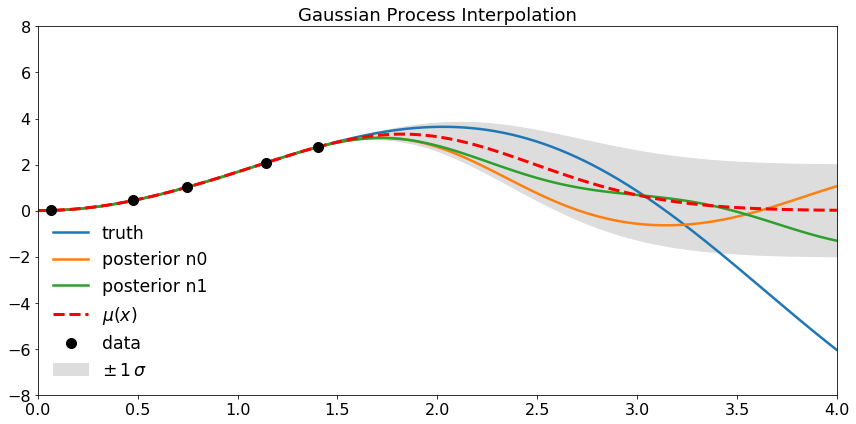

In [20]:
perform_gp_prediction(xtrain,ytrain,0.5)